In [1]:
%matplotlib inline
from __future__ import division
from quantecon.lucas_search_ns import LucasSearch
from quantecon.lucas_search_general import LucasSearchGeneral
import numpy as np
import matplotlib.pyplot as plt
from quantecon.compute_fp import compute_fixed_point

### Equilibrium Search and Unemployment - Robert Lucas and Edward Prescott - 1974

*I removed the stochastic arrival part of the LucasPrescott74 notebook in order to create this. The qualitative results are the same.*  

[1. The Model](#The-Model)  
[2. The Value Function](#The-Value-Function)  
[3. Employment](#Employment)  
[4. Workforce Dynamics](#Workforce-Dynamics)  
[4. Simulation](#Simulation)  
[5. Equilibrium](#Equilibrium)  
[6. Appendix](#Appendix)  
[7. References](#References)


###The Model

Consider an *island economy*. There is a continuum of workers distributed among the islands. Each island contains a perfectly competitive industry that uses labor to produce their final good. Also, each island faces a stochastic demand.  
At each period, workers decide whether to stay and work in the island at the current wage, or move to another island. Moving out means not working in that period.  

Since the industry is competitive, wages must equal the marginal return of labor; which gives a labor demand function. As the labour demand depends on the stochastic demand of the final good, the labor demand function will be stochastic as well. At any time, the amount of labor demanded must be less than the number of workers in the island.


**Model Specifications**

```python
    class LucasSearch(object):
        def __init__(self, beta=.9, states=[1, 2], transition=[[.9, .1], [.1, .9]], lamb=3):
            self.beta = beta
            self.states = states
            self.transition = transition
            self.labour_demand = lambda n, s: (s/2)*(1-.01*n)
            self.grid = np.linspace(0, 200, 201)
            self.lamb = lamb
```
In order to compute the equilibrium, the labour space and the states of the demand have been discretized.  
As usual, **beta** is the discount factor and **transition** is the transition matrix for the states of demand.  
The labour demand function takes the form $R(s,\, n) = s/2\cdot(1-\frac{n}{100})$, where $n$ is the amount of labour employed and $s$ is the state of the demand.  
As I am computing the *partial* equilibrium, $\lambda$ (**lamb** in the code) is exogenously given. This will be explained later.

I selected the default values in order to replicate part of Figure 5 of the paper.

In [2]:
#Instantiating the model with the default specification
ls = LucasSearch()

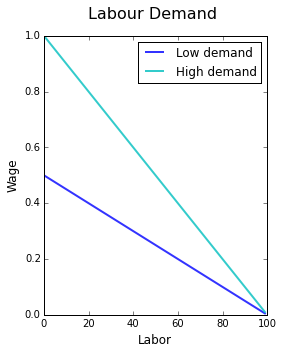

In [3]:
#Plotting the labour demand function
fig, ax = plt.subplots(figsize=(4,5))
ax.set_xlabel("Labor", fontsize=12)
ax.set_ylabel("Wage", fontsize=12)

wages = [[ls.labour_demand(n, s) for n in ls.grid[:100]] for s in ls.states]

ax.plot(ls.grid[:100], wages[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid[:100], wages[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper right')

t = 'Labour Demand'
fig.suptitle(t, fontsize=16)

plt.show()

###The Value Function
In this model, workers are the only ones who decide what to do. The decision they face is whether to stay (and work) in the island they are in, or leave the island and search for another one. Thus, workers must compare how much utility they would get from staying in that island and how much they would get if they were to venture into a different island.

Let's say that the value (the discounted expectation of all earnings) of leaving the island is represented by $\lambda$. Workers take this *value of search* as given. Call this **Case A**. $$ v_{a}(s,\, y,\, \lambda) = \lambda $$

The value associated with staying in the island is a more interesting expression. First, staying in the island means the worker is employed and receiving a wage. However, staying in the island means being there in the next period. Thus, the value of staying can be written as a recursive function. Call this **Case B**.  $$ v_{b}(s,\, y,\, \lambda) = R(s,\, n) + \beta E[v(s',\, y',\, \lambda) | s,\, y,\, \lambda]$$

The second term of this value function is the (discounted) future value of the island. This value can't be too high. If it were, workers would be attracted to that island until it is as good as all other possible islands. So, the (discounted) future value of the island has an upper bound; and this upper bound is $\lambda$. Rewriting **Case B** value function: $$ v_{b}(s,\, y,\, \lambda) = R(s,\, n) + min(\lambda,\, \beta E[v(s',\, y',\, \lambda) | s,\, y,\, \lambda])$$

Finally, workers would decide for the choice with the highest value. Then, the value function for a worker in an island with state *s*, workforce size *y* and value of search $\it{\lambda}$ would be:

$$ v(s,\, y,\, \lambda) = max[\lambda,\, R(s,\, n) + min(\lambda,\, \beta E[v(s',\, y',\, \lambda) | s,\, y,\, \lambda])] $$


**Computing the value function**

I use the Bellman operator to solve for the functional equation above:  

```python
    def bellman_operator(self, v):
        Av = [InterpolatedUnivariateSpline(self.grid, v[i], k=3) for i in xrange(self.states.size)]
		Avx = lambda y: np.asarray([function(y) for function in Av]) 
        case_a = self.lamb
		
        Tv = np.asarray([np.empty(self.grid.size)]*self.states.size)
		for i, y in enumerate(self.grid):
			for j, state in enumerate(self.states):
				case_b1 = self.labour_demand(y, state) + self.beta*np.dot(self.transition[j], Avx(i))
                case_b2 = self.labour_demand(y, state) + self.lamb
				
				Tv[j][i] = max(case_a, min(case_b1, case_b2))
		return Tv
```
The Bellman operator takes an arbitrary value function (defined as a vector containing the value for each possible state) and calculates a new value function following the functional equation previously defined. Repeated application of the Bellman operator results on the *correct* value function, the one that satisfies the equation. 

The following code plots the value function for a worker (not necessarily employed) that finds himself in an island with low/high demand and a workforce of size $y$.

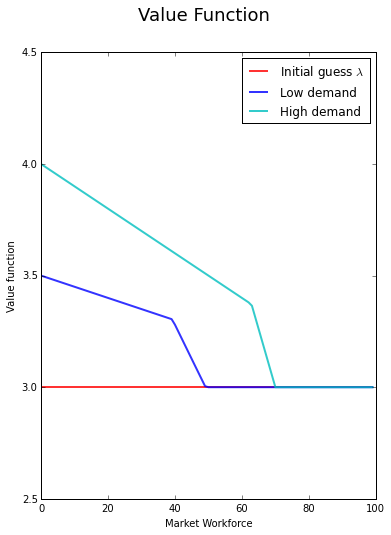

In [4]:
# Expected present value of the wage stream for a worker #

fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Value function")
ax.set_ylim((2.5,4.5))
v = np.asarray([np.ones(ls.grid.size)*ls.lamb]*ls.states.size)
ax.plot(ls.grid[:100], v[0][:100], 'r-', lw = 2, alpha = .8, label=r'Initial guess $\lambda$')

v_star = compute_fixed_point(ls.bellman_operator, v, verbose=0)
ax.plot(ls.grid[:100], v_star[0][:100], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid[:100], v_star[1][:100], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper right')

t = 'Value Function'
fig.suptitle(t, fontsize=18)

plt.show()

Clearly, there are three possibilities for the value function.  

At the right-hand side, the value function is equal to $\lambda$ and the island is in **Case A**. The island has a larger workforce than it requires. This means some workers are leaving and some remain.  

At the left-hand side, the market has a truly low workforce. The demand for labour is higher than the number of workers in the market. In the next period, this market would receive an influx of additional workers from other markets. This is what the authors call **Case B2**.  

At the middle, all the workers in the market are hired. However, unlike **Case B2**, the demand for labour is not so high as to entice outside workers to come to this market. This is what the authors call **Case B1**

###Employment
**Calculating the Employment rate**

The number of employed workers is the entire workforce in **Case B1** and **Case B2**. 

However, in **Case A**, not all workers are hired. Since only workers that were hired remain for the next period, this means that the number of employed workers $n$ satisfies the following equation:  

$$ v(s,\, y,\, \lambda) = R(s,\, n) + \beta E[v(s',\, n,\, \lambda) | s,\, y,\, \lambda] = \lambda$$

```python
	def unconstrained_employment(self, v):
		Av = [InterpolatedUnivariateSpline(self.grid, v[i], k=3) for i in xrange(self.states.size)]
		Avx = lambda y: np.asarray([function(y) for function in Av])
		
		function = [lambda n, s=state: self.labour_demand(n, s) + 
					self.beta*np.dot(self.transition[j], Avx(n)) - 
					self.lamb for j, state in enumerate(self.states)] 
		
		n_hat = [int(fsolve(function[j], self.grid.max()/2)) for j in xrange(self.states.size)]
		return n_hat

    def compute_employment(self, v):
		n_hat = self.unconstrained_employment(v)
		n_eq = np.asarray([np.empty(self.grid.size)]*self.states.size)
				
		#Imposes the workforce constraint if it is binding
		for j in xrange(self.states.size):
			n_eq[j] = np.maximum(0,np.minimum(n_hat[j], self.grid))
					
		return n_eq

```

The first function computes the unconstrained employment, the number of workers that would be hired in an island withut taking into account the workforce size. In order to do this, the function looks for the level of employment that makes workers indifferent between staying and leaving (the zero in **function**).

The second function imposes the workforce constraint when it is binding. We can see that this constraint is binding in **Case B** and not binding in **Case A**.


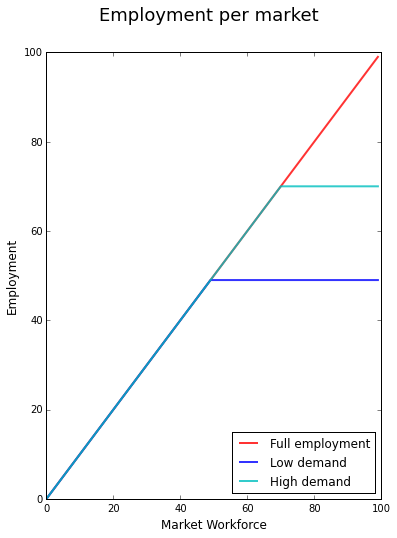

In [5]:
# Employment Plot #

fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlabel("Market Workforce", fontsize=12)
ax.set_ylabel("Employment", fontsize=12)

employment = ls.compute_employment(v_star)
ax.plot(ls.grid[:100], ls.grid[:100], 'r-', lw = 2, alpha = .8, label = "Full employment")
ax.plot(ls.grid[:100], employment[0][:100], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid[:100], employment[1][:100], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'lower right')

t = 'Employment per market'
fig.suptitle(t, fontsize=18)

plt.show()

It is pretty clear that there is a maximum number of workers that firms can hire. This maximum number depends on the state of demand of the island. Having more workers in the island than this maximum results in unemployment.

**Why aren't the rest of the workers hired?**

For one, firms cannot hire more workers at the same wage as they are already hiring the optimal amount. The marginal value of labour is already equal to the wage, so hiring a new worker would increase the production by less than his wage. In order to hire more workers, the wage would have to be lower.

However, wages cannot decrease any further. If wages were any lower, workers would prefer to leave their employments and search for a job in a different island. 

In a nutshell, firms cannot hire more workers at current wages and wages cannot decrease because if they did, employees would rather go search for a job at a different market.

**Unemployment Plot**  
This plot shows the number of unemployed workers in a market with a high/low state of demand and a workforce of size **y**.

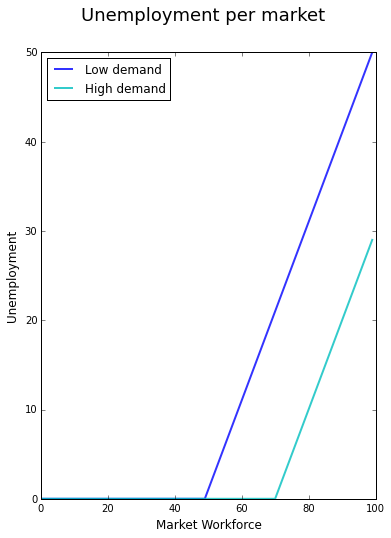

In [6]:
# Unemployment Plot #

fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlabel("Market Workforce", fontsize=12)
ax.set_ylabel("Unemployment", fontsize=12)

unemployment= [ls.grid[:100] - employment[0][:100], ls.grid[:100] - employment[1][:100]] 

ax.plot(ls.grid[:100], unemployment[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid[:100], unemployment[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper left')

t = 'Unemployment per market'
fig.suptitle(t, fontsize=18)

plt.show()

This plot shows clearly how markets have an upper bound for the number of workers they can accomodate. Having a workforce that is larger than this upper bound means the excess workers will be unemployed.

**How does the value of search ($\lambda$) affect the amount of labor demanded?**

Since workers can either search for a job (in a different island) or accept their job offer; the value of search is a lower bound to the value of getting a job.  

In a traditional, Walrasian market, the value of search is zero (because workers cannot search for a job). In that case, the opportunity cost of getting a job for the worker is effectively zero. Thus, the wage $w$ will adjust as low as necessary, in order to accomodate the complete workforce.  

In this particular model, wages do have a lower bound. If wages were so low as to make the value of taking the job offer less than the value of search, no worker would take the job and the complete workforce would leave the island. Hardly an equilibirum outcome.  

Following this reasoning, a higher $\lambda$ lowers the amount of labor demanded in every particular island. 

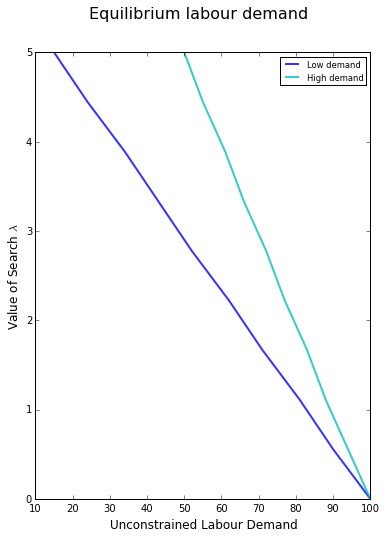

In [7]:
lambdas = np.linspace(0, 5, 10)
demand_high = np.empty(len(lambdas))
demand_low = np.empty(len(lambdas))

for i, lam in enumerate(lambdas):
    L = LucasSearch(lamb=lam)
    v = np.asarray([np.ones(L.grid.size)*L.lamb]*len(L.states))
    v_star = compute_fixed_point(L.bellman_operator, v, verbose=0)
    demand_low[i] = L.unconstrained_employment(v_star)[0]
    demand_high[i] = L.unconstrained_employment(v_star)[1]

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_xlabel("Unconstrained Labour Demand", fontsize=12)
ax.set_ylabel(r"Value of Search $\lambda$", fontsize=12)

ax.plot(demand_low, lambdas, 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(demand_high, lambdas, 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper right', fontsize='small')

t = 'Equilibrium labour demand'
fig.suptitle(t, fontsize=16)

plt.show()

###Workforce Dynamics
**Workforce in next period**

Let's assume (as the authors do) that unemployed workers are perfectly directed towards the markets that most need them.  

Markets with a small workforce (**Case B2**) receive enough workers such that the value of search is equal to the expected value of taking a job in that market taking into account the additional workers.  
Markets with a large workforce (**Case A**) keep only those workers that were hired.  
In **Case B1**, the workforce remains the same since there is no incentive for new workers to go to this market and the whole workforce is employed. 

```python
    def next_workforce(self, v):
		n_eq = self.compute_employment(v) #Calculates the number of employed workers
		next_wf = np.asarray([np.empty(self.grid.size)]*self.states.size) 

		for j, state in enumerate(self.states):
			for i, y in enumerate(self.grid):
				if n_eq[j][i] == y: # This means we are in case B1 or B2
                    e_value =[self.beta*np.dot(self.transition[j], Avx(y + a)) < self.lamb for a in xrange(100)]
					try:
						a_star = e_value.index(True) # This function gives the first a for which the function
					except ValueError:
						a_star = 0				 	 # self.beta*np.dot(self.transition[j], Avx(y + a)) - self.lamb
												 	 # becomes negative. Thus, it is the (expected if stochastic)
												 	 # number of workers arriving in the next period. 
					next_wf[j][i] = y + a_star
				
				else: # This is case A 
					next_wf[j][i] = next_wf[j][i-1] #As no more workers are being hired, 
													#next period workforce is the same as 
													#for a market with one less worker 	
									
		return next_wf
```

In **Case B2**, additional workers are arriving to the island. The number of workers arriving is such that the value of the island after they arrive is as good as searching for other island. 
$$ \beta E[v(s',\, y + a*x,\, \lambda) | s,\, y,\, \lambda] = \lambda$$

If we assume there is randomness in the arrival to the island, the equation to satisfy is: 
$$ \beta E_{x}[\, E_{s}[v(s',\, y + a*x,\, \lambda) | s,\, y,\, \lambda]\,] = \lambda$$

$a$ is the number of incoming workers. 

In **Case A**, the next period workforce is the number of workers hired. The unemployed workers leave and there are no incoming workers.

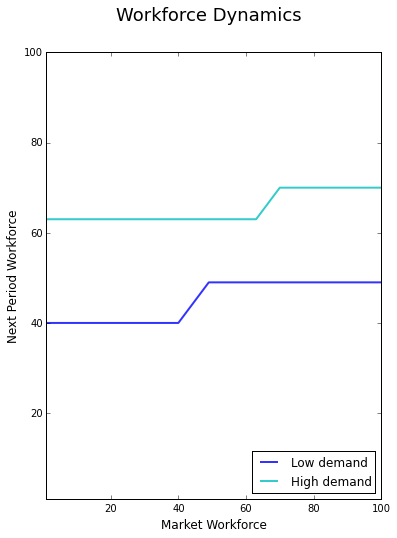

In [8]:
v = np.asarray([np.ones(len(ls.grid))*ls.lamb]*len(ls.states))
v_star = compute_fixed_point(ls.bellman_operator, v, verbose=0)
new_wf = ls.next_workforce(v_star)

fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlabel("Market Workforce", fontsize=12)
ax.set_ylabel("Next Period Workforce", fontsize=12)
ax.set_ylim((1,100))
ax.set_xlim((1,100))

ax.plot(ls.grid, new_wf[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, new_wf[1], 'c-', lw = 2, alpha = .8, label = "High demand")
#ax.plot(ls.grid, ls.grid, 'r-', lw = 2, alpha = .8, label = "Identity")

ax.legend(loc = 'lower right')

t = 'Workforce Dynamics'
fig.suptitle(t, fontsize=18)

plt.show()

This graph shows the transition between the size of the workforce for an island assuming no randomness in the process of moving to another island. 

For instance, let's say there is an island with 20 workers and low demand. Next period, about 20 more workers will go into the island for a total of about 40 workers. If in the next period, the state of demand changes from low to high; the period after that will have a little more than 60 workers, and so on.

It is easy to see that the workforce size will stay constant for as long as the state of demand stays the same and that it will go in a cycle when the state of demand changes. The workforce size will cycle between the maximum next-period workforce of the low demand state and the minimum next-period workforce of the high demand state. *(see Excercise 26.1 a. of RMT)*

####Markov Transition Matrix
The dynamics of the workforce could be described as a Markov Chain. It is possible to define a transition matrix that fully describes this process.

```python
    def markov_transition(self, v=None):
		if v == None:
			v = np.asarray([np.zeros(self.grid.size)]*self.states.size)
			v = compute_fixed_point(self.bellman_operator, v, verbose=0, max_iter=30)
		
		new_wf = self.next_workforce(v)
		pll, plh, phl, phh = self.transition.flatten()
		
        I = np.hstack((self.grid, self.grid, self.grid.size + self.grid, self.grid.size + self.grid))
        J = np.hstack((new_wf[0], self.grid.size + new_wf[0], new_wf[1], self.grid.size + new_wf[1]))
        V = np.hstack((pll*np.ones(self.grid.size), plh*np.ones(self.grid.size), 
                        phl*np.ones(self.grid.size), phh*np.ones(self.grid.size)))
		
		A = coo_matrix((V,(I,J)),shape=(self.state.size*self.grid.size, self.grid.state*self.grid.size))

		M = A.tocsr().transpose()
```

The transition matrix has to account for every possible combination of workforce size and state of demand. This gives a very large matrix. Since many of these values are zero, it is possible to use a sparse matrix. Using a sparse matrix, I only need to specify the nonzero elements.

In the code snippet, **I** is the row index vector, **J** is the column index vector and **V** is the value to be placed at each one of this "row, column" points.

The Markov transition formulation is very useful as we will see later.

*The code for the stochastic arrival case is also available but I decided to leave it out as it is not as clean and easy to understand at a first glance.*

###Simulation
**Simulating the history of a given island**  

The following plot shows the simulated path for an economy

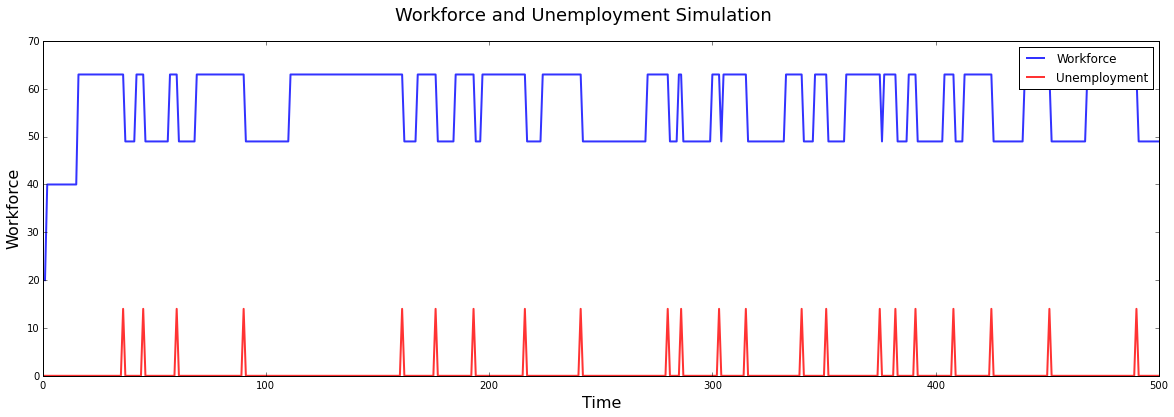

In [9]:
next_wf = lambda y, state: new_wf[state][list(ls.grid).index(y)] 
# next period workforce for an island with workforce y and state of demand = state

employment = ls.compute_employment(v_star)

unemployment = lambda y, state: y - employment[state][list(ls.grid).index(y)]
# number of unempployed for an island with workforce y and state of demand = state

#Initial Values
wf = 20 # starting workforce
T = 5000 # Number of periods
s = 0 # starting in a low demand state

#Initializing the arrays
wf_history = np.empty(T)
un_history = np.empty(T)
unrate_history = np.empty(T)

#Writing history
for i in xrange(T):
    wf_history[i] = wf
    un_history[i] = unemployment(wf, s)
    unrate_history[i] = 100*unemployment(wf, s)/wf
    wf_1 = next_wf(wf, s)
    if wf_1 > wf:
        wf = wf + int((next_wf(wf, s) - wf)) 
    else:
        wf = wf_1
    s = np.random.choice(ls.states, p = ls.transition[s]) - 1
    
time = np.linspace(1, T, T)

#Plotting
fig, ax = plt.subplots(figsize=(20,6))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Workforce", fontsize = 16)

ax.plot(time[:500], wf_history[:500], 'b-', lw = 2, alpha = .8, label = "Workforce")
ax.plot(time[:500], un_history[:500], 'r-', lw = 2, alpha = .8, label = "Unemployment")


ax.legend(loc = 'upper right')

t = 'Workforce and Unemployment Simulation'
fig.suptitle(t, fontsize=18)

plt.show()

If a market starts with a low workforce, over time it attracts more workers. A market with a low workforce pays higher wages and that is the incentive for workers to go there.  
The fluctuations in the unemployment and the workforce size correspond to changes in the state of demand.

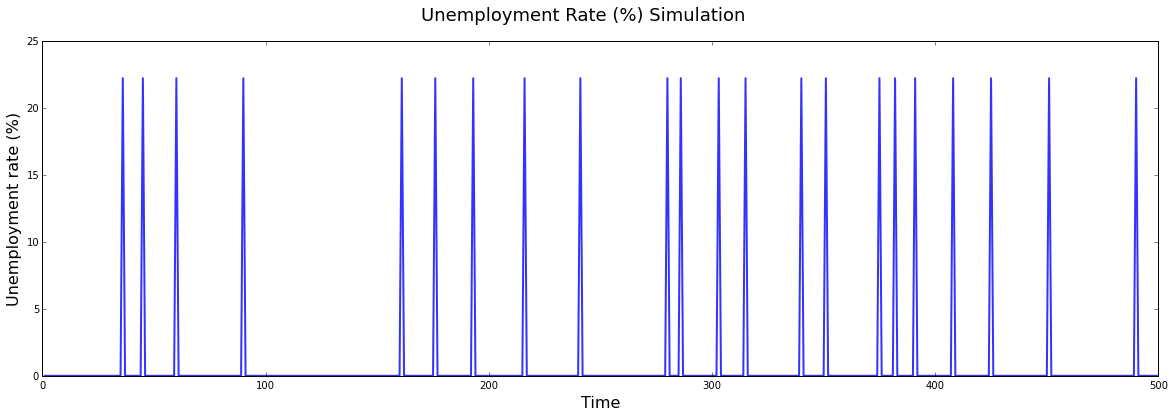

In [10]:
fig, ax = plt.subplots(figsize=(20,6))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Unemployment rate (%)", fontsize = 16)

ax.plot(time[:500], unrate_history[:500], 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right')

t = 'Unemployment Rate (%) Simulation'
fig.suptitle(t, fontsize=18)

plt.show()

In order to appreciate the economic cycles, we can look at the moving average of our simulated time series. The natural cycle of the economy between high and low states of demand and the randomness in the arriving process generate these fluctuations.

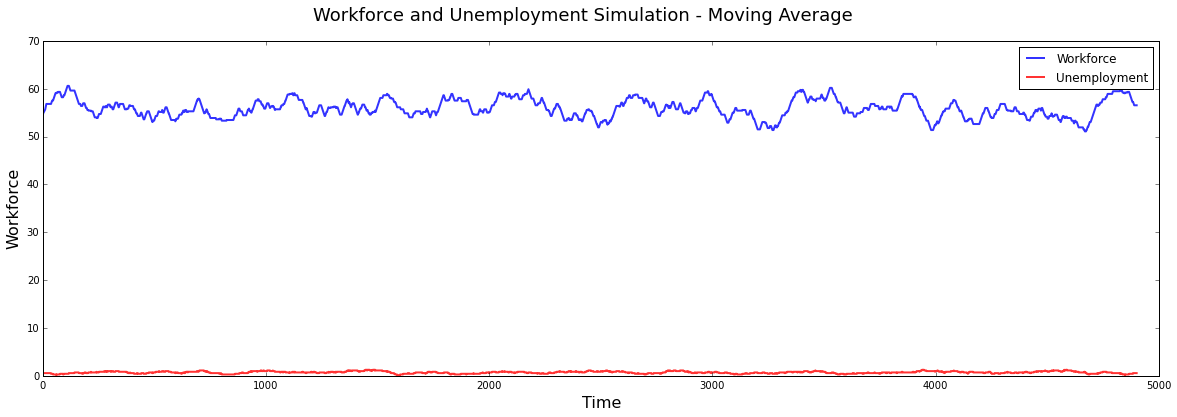

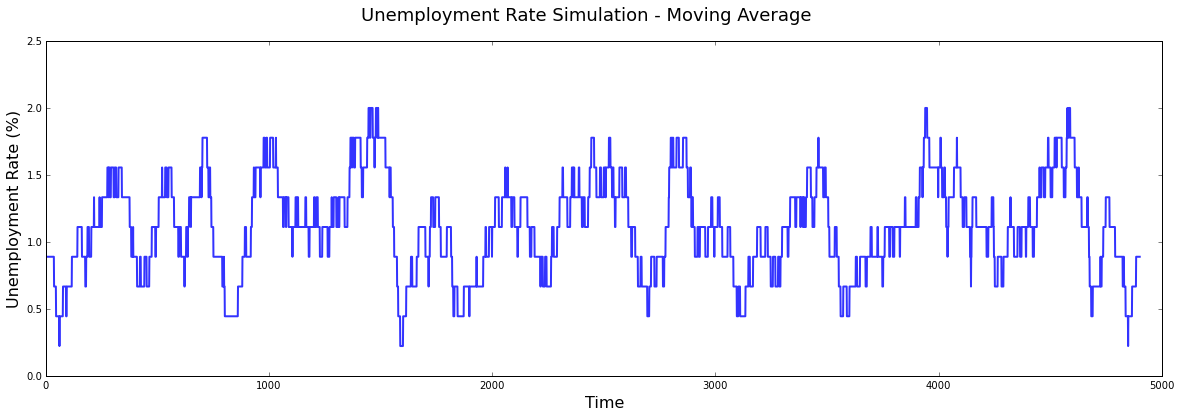

In [11]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

N = 100 # Number of periods for moving average

wf_history_ma = moving_average(wf_history, n=N)
un_history_ma = moving_average(un_history, n=N)
unrate_history_ma = moving_average(unrate_history, n=N)
time_ma = np.linspace(1, len(unrate_history_ma), len(unrate_history_ma))

#Plotting Workforce size and unemployyment
fig, ax = plt.subplots(figsize=(20,6))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Workforce", fontsize = 16)

ax.plot(time_ma, wf_history_ma, 'b-', lw = 2, alpha = .8, label = "Workforce")
ax.plot(time_ma, un_history_ma, 'r-', lw = 2, alpha = .8, label = "Unemployment")

ax.legend(loc = 'upper right')

t = 'Workforce and Unemployment Simulation - Moving Average'
fig.suptitle(t, fontsize=18)

plt.show()

#Plotting the unemployment rate
fig, ax = plt.subplots(figsize=(20,6))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Unemployment Rate (%)", fontsize = 16)

ax.plot(time_ma, unrate_history_ma, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right')

t = 'Unemployment Rate Simulation - Moving Average'
fig.suptitle(t, fontsize=18)

plt.show()

###Equilibrium
** Computing the economy equilibirium ** 

We have been calculating results taking the *value of search* $\lambda$ as given.

However, the *value of search* is determined by the conditions of the economy. In an economy with a large number of workers, it's harder to find a job. Also, wages are likely to be lower as there is a lot of labor supply. Thus, the *value of search* should be lower in economies (not to be confused with islands) with a larger workforce. 

We can compute the *value of search* in two different ways.

First, taking advantage of the code written so far, we can compute the average workforce associated with a particular *value of search*. 

Then, for an economy with a given average workforce size per island, we can find the equilibirum *value of search* ($\lambda$) by looking at the corresponding value in the relation established above.

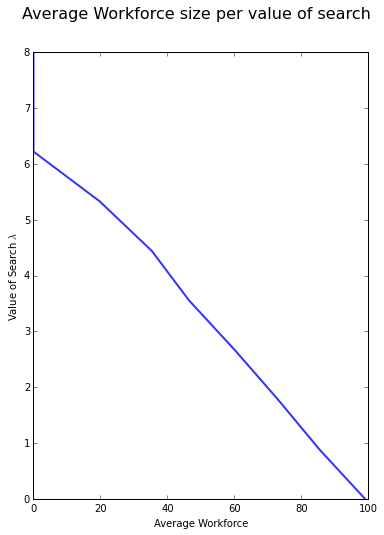

In [12]:
lambdas = np.linspace(0, 8, 10)
horizon = 50

workforce_mean = np.empty(len(lambdas))

for i, lam in enumerate(lambdas):
    L = LucasSearch(lamb=lam)
    wf = np.linspace(0, 100, 101)
    v = np.asarray([np.zeros(len(L.grid))]*len(L.states))
    v_star = compute_fixed_point(L.bellman_operator, v, verbose=0, max_iter=30)
    new_wf = L.next_workforce(v_star)
    
    for j in xrange(horizon):
        states = np.random.randint(2, size=len(wf))
        wf = [new_wf[states[k]][list(L.grid).index(y)] if y!= 0 else 0 for k, y in enumerate(wf)] 
        change = np.random.choice((0,1), p=(.9, .1), size=len(wf)) # 1 if the state changes, 0 otherwise
        states = (states + change)%2 # Computes the new state

    workforce_mean[i] = np.asarray(wf).mean()

#Plotting
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_xlabel("Average Workforce")
ax.set_ylabel(r"Value of Search $\lambda$")

ax.plot(workforce_mean, lambdas, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right', fontsize='small')

t = 'Average Workforce size per value of search'
fig.suptitle(t, fontsize=16)

plt.show()

This way of computing the relation between average workforce and *value of search* is somewhat time intesive. A more efficient way of doing this is by using the Markov transition matrix defined above.  

Let's start by defining **vec** as a vector holding an arbitrary initial distribution of islands over workforce sizes and states of demand. The first element of **vec** would be the percentage of islands that are in (or the probability of an island to be in) a low demand state and have a workforce of zero. 

The vector with the distribution for the next period can be obtained by multiplying this vector with the Markov transition matrix (**M**). The equilibrium distribution will be such that $ v^{*} = M v^{*} $. Repeated application of this procedure will result in the equilibrium distribution of workforces and states.

The following code implements this procedure.

```python
	def compute_eq(self, M, vec=None, compute_unemployment=True, error_tol=1e-6, max_iter = 1000):

		if vec == None:
            vec = np.ones(self.states.size*self.grid.size)/(self.states.size*self.grid.size)

		error = 1
		iter = 1
		V = vec
		while error > error_tol and iter < max_iter:
			new_V = M.dot(V)
			error = np.max(np.abs(V-new_V))
			V = new_V
			iter += 1

		if compute_unemployment:
			employment = self.compute_employment()
			unemployment = np.tile(self.grid, self.states.size) - employment.flatten()
            unem = V.dot(unemployment)
			
			return V, unem	
		return V

```

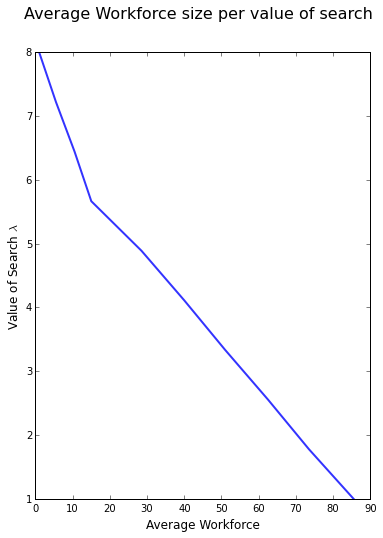

In [13]:
ls = LucasSearch()
lambdas = np.linspace(1, 8, 10)
work = np.empty(lambdas.size)
vec = np.ones(2*ls.grid.size)/(2*ls.grid.size)

for i, lam in enumerate(lambdas):
    ls.lamb = lam
    M = ls.markov_transition()  
    d, u = ls.compute_eq(M, vec)
    wf = d.dot(np.tile(ls.grid, ls.states.size))
    work[i] = wf

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_xlabel("Average Workforce", fontsize=12)
ax.set_ylabel(r"Value of Search $\lambda$", fontsize=12)

ax.plot(work, lambdas, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right', fontsize='small')

t = 'Average Workforce size per value of search'
fig.suptitle(t, fontsize=16)

plt.show()


This procedure is not only faster but also more reliable. Since we are modeling the whole distribution, it is as if we were running the previous code with a very large number of islands. 

Now, we can say that an economy with an average workforce size of 40 will have a *value of search* approximately equal to 4.
In this plot, we can correctly plot the kink at about 5.5. 

Now, we'll see why this kink occurs. 

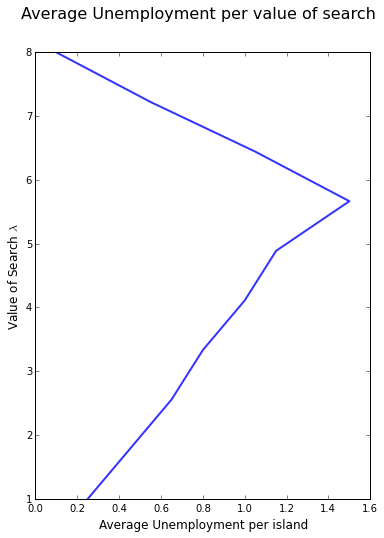

In [14]:
ls = LucasSearch()
lambdas = np.linspace(1, 8, 10)
unem = np.empty(lambdas.size)
vec = np.ones(2*ls.grid.size)/(2*ls.grid.size)

for i, lam in enumerate(lambdas):
    ls.lamb = lam
    M = ls.markov_transition()
    d, u = ls.compute_eq(M, vec)
    employment = ls.compute_employment()
    unemployment = np.tile(ls.grid, 2) - employment.flatten() 
    unem[i] = d.dot(unemployment)

#Unemploymen
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_xlabel("Average Unemployment per island", fontsize=12)
ax.set_ylabel(r"Value of Search $\lambda$", fontsize=12)

ax.plot(unem, lambdas, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right', fontsize='small')

t = 'Average Unemployment per value of search'
fig.suptitle(t, fontsize=16)

plt.show()

*This graph replicates Figure 5 of the paper*

The average unemployment has a maximum and this is causing the kink in the average workforce function. An important question is why there is a kink at all. 

A higher $\lambda$ makes workers more likely to leave an island, since search is more valuable. Thus, a higher $\lambda$ is related to more unemployment. Let's call this the *search effect*.
However, $\lambda$ is also related to the workforce size. A higher $\lambda$ is related to a lower workforce size and higher wages (since there is less competition among workers). Higher wages makes workers more likely to stay and, therefore, reduce unemployment. Let's call this the *wage effect*.

For low values of $\lambda$ the *search effect* is bigger than the *wage effect* and the relation between $\lambda$ and unemployment is positive. But, at the level of the kink, the *wage effect* becomes bigger than the *search effect* and the relation reverses.


###Appendix 
*(Thinking of deleting this part)*  
**Computing $\lambda$ with few islands** 

This form of calculating $\lambda$ depends on a crucial assumption. The assumption is that the number of islands in the economy is really large. It has to be large enough (a continuum) so that even though islands face a stochastic demand, the aggregate demand of the economy is constant.

If this assumption failed and the aggregate demand were to be stochastic, then $\lambda$ should change to reflect this. A lower aggregate demand should be associated with a lower *value of search*. 

This way of computing the value of search is not based on the assumption of a continuum of islands. However, it requires us to specify the number of islands and the number of workers per island. 

The following code computes the value of lambda for an arbitrary economy. An economy is defined as a group of islands and each island is defined by its workforce (the number of workers) and its state of demand. 

```python
class LucasSearchGeneral(object):

    def __init__(self, beta=.9, states=[1, 2], transition=[[.9, .1], [.1, .9]], 
					islands_wf = [50]*100, islands_state = [0]*50 + [1]*50,
					stochastic=False): 
	
        self.beta = beta
		self.states = states
		self.transition = transition
		self.islands_wf = islands_wf
		self.islands_state = islands_state
		self.stochastic = stochastic
```

The model needs a complete specification of the economy. That is a workforce and state of demand for each island. 

Since we assume a fixed number of workers in the economy. The equilibrium *value of search* in a given period is such that the net change in workforce in the economy is zero. 

We could easily simulate an economy with an increasing workforce. We would need to establish that the equilibrium *value of search* makes the net change in workforce be positive and equal to the workforce rate of growth. 

```python
    def net_moves(self, l):
		wf_change = LucasSearch(beta=self.beta, states=self.states,
                                    transition=self.transition,lamb=l).workforce_change(stochastic=self.stochastic)
                                    
		return np.asarray([wf_change[state][y] for state, y in izip(self.islands_state, self.islands_wf)]).sum()
```

The function **net_moves** takes as argument a possible *value of search* ($\lambda$) and, assuming that particular value, computes the change in the workforce for each of the islands. 

The equilibirum *value of search* ($\lambda^{*}$) satisfies $\text{net_moves}(self,\, l \, = \, \lambda^{*}) = 0 $  

```python
    def get_lambda(self):
  
        change = lambda l: self.net_moves(l)
		lambda_star = brenth(change, 0, 10)
		return lambda_star
```

$\lambda$ could be found using a typical (non-linear) equation solving algorithm. **brenth** is an application of Brent's method, which is a combination of the bisection method, the secant method and inverse quadratic interpolaton.    



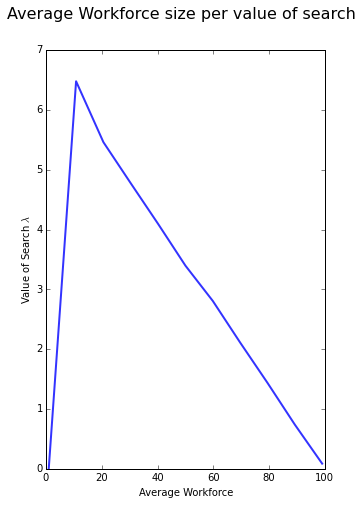

In [15]:
avg = np.linspace(1, 99, 11)
number_of_islands = 10000
number_high_demand = int(.5*number_of_islands)

lambdas = [LucasSearchGeneral(islands_wf=[average_workforce]*number_of_islands, 
                              islands_state=[0]*(number_of_islands-number_high_demand)+[1]*(number_high_demand)).get_lambda() 
                               for average_workforce in avg]

fig, ax = plt.subplots(figsize=(5, 7.5))
ax.set_xlabel("Average Workforce")
ax.set_ylabel(r"Value of Search $\lambda$")

ax.plot(avg, lambdas, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right', fontsize='small')

t = 'Average Workforce size per value of search'
fig.suptitle(t, fontsize=16)

plt.show()

We should take into account that, in this case with only a few islands, $\lambda$ not only depends on the aggregate state of demand but also on the distribution of workers across the islands. For the plot above, we calculated the *value of search* for an economy with the same workforce in each island. Evidently, some workers need to be reallocated in this economy. 

**Simulating the complete economy**

Now that we have a way to simulate the dynamics of any island economy. 

This simulation is for an economy with 100 islands and an average of 45 workers per island. As starting point, islands have the same number of workers and half of them are in a high demand state. This simulation supposes a deterministic arrival process. 


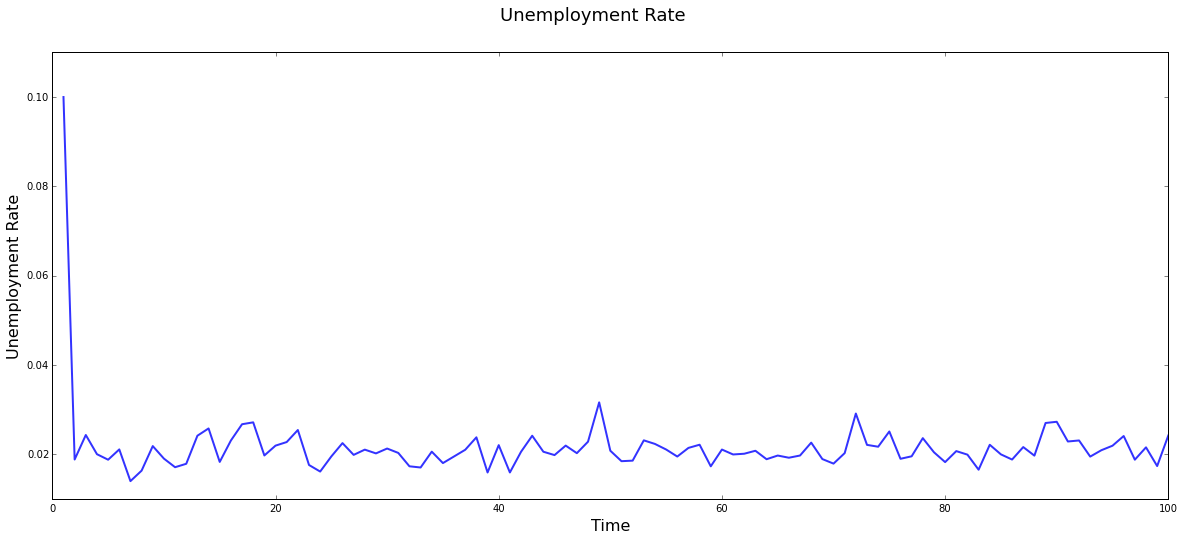

In [16]:
number_of_islands = 1000
average_workforce = 45
number_high_demand = int(.5*number_of_islands)

#LSG = LucasSearchGeneral(islands_wf=[37]*(number_of_islands-number_high_demand) + [53]*(number_high_demand), 
#                         islands_state=[0]*(number_of_islands-number_high_demand)+[1]*(number_high_demand))

LSG = LucasSearchGeneral(islands_wf=[average_workforce]*(number_of_islands), 
                         islands_state=[0]*(number_of_islands-number_high_demand)+[1]*(number_high_demand))
t = 100
time = np.linspace(1,t,t)
l, s, u = LSG.simulate(T=t, compute_unemployment=True) 

#Plotting the Unemployment Rate
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Unemployment Rate", fontsize = 16)

ax.plot(time, u, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right')

t = 'Unemployment Rate'
fig.suptitle(t, fontsize=18)

plt.show()


We can observe the level of unemployment never getting to zero. Since at any given time, some islands' state of demand is changing and the workers in those islands need to reallocate.  

We can also plot the *value of search* and the average state of demand of the economy. 

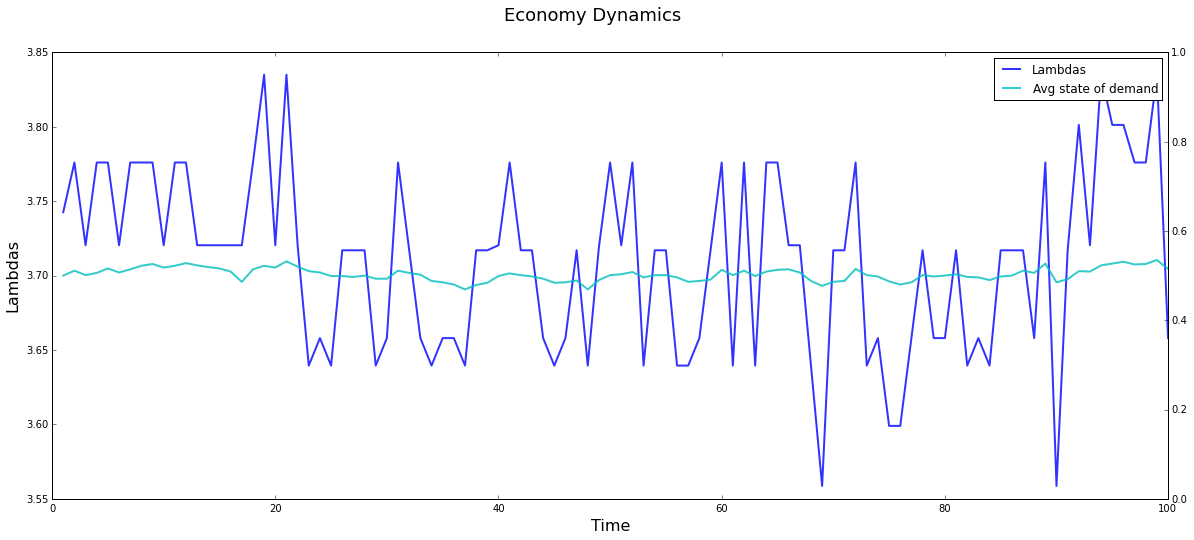

Correlation state of demand and value of search: 0.73


In [17]:
#Plotting the dynamics of lambda and the state of demand
fig, ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Lambdas", fontsize = 16)
#ax.set_ylim(2,6)
ax2.set_ylim(0,1)
plot1 = ax.plot(time, l, 'b-', lw = 2, alpha = .8, label="Lambdas")
plot2 = ax2.plot(time, s, 'c-', lw=2, alpha=.8, label="Avg state of demand")

plots = plot1 + plot2
labels = [p.get_label() for p in plots]
ax.legend(plots, labels, loc = 'upper right')

t = 'Economy Dynamics'
fig.suptitle(t, fontsize=18)

plt.show()

## Correlation
print r"Correlation state of demand and value of search: {0:.2g}".format(np.corrcoef(l,s)[0,1])

The relationship between these two variables is not very clear. However, if we look at the first difference time series, the relationship becomes evident.

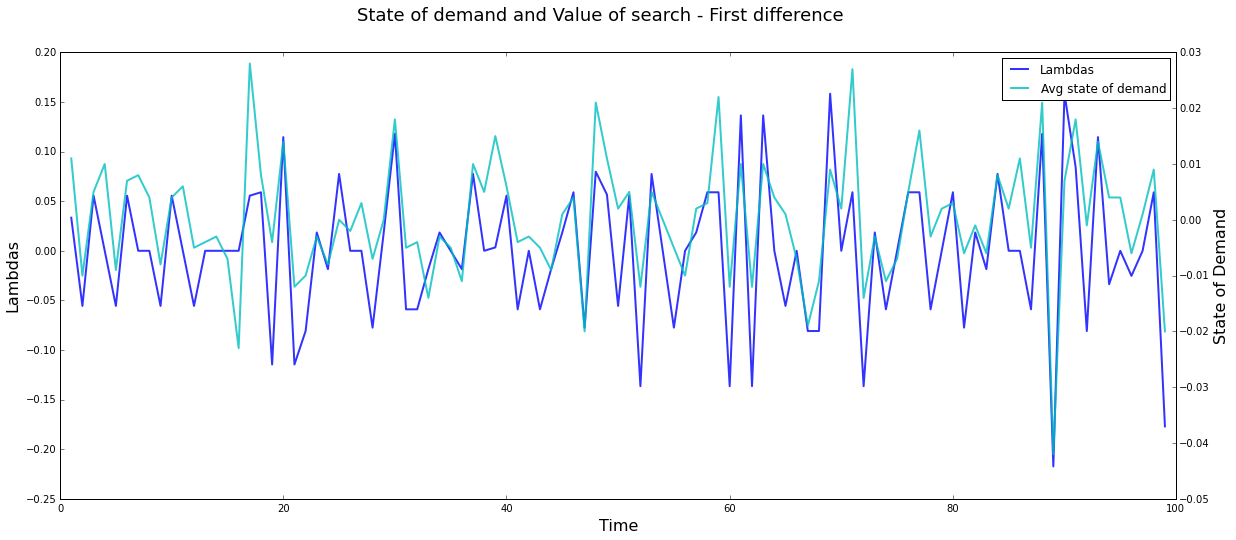

Correlation state of demand and value of search - First difference: 0.77


In [18]:
#Plotting the dynamics of lambda and the state of demand. First Difference.
dl = [l[i] -l[i-1] for i in xrange(1,len(l))]
ds = [s[i] -s[i-1] for i in xrange(1,len(s))]
time2 = np.linspace(1, len(dl), len(dl))

fig, ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Lambdas", fontsize = 16)
ax2.set_ylabel("State of Demand", fontsize = 16)

plot1 = ax.plot(time2, dl, 'b-', lw = 2, alpha = .8, label="Lambdas")
plot2 = ax2.plot(time2, ds, 'c-', lw=2, alpha=.8, label="Avg state of demand")

plots = plot1 + plot2
labels = [p.get_label() for p in plots]
ax.legend(plots, labels, loc = 'upper right')

t = 'State of demand and Value of search - First difference'
fig.suptitle(t, fontsize=18)

plt.show()

##Correlation
print r"Correlation state of demand and value of search - First difference: {0:.2g}".format(np.corrcoef(dl,ds)[0,1])

As predicted above, when the economy's aggregate demand rises, the *value of search* rises as well. 

The *value of search* $\lambda$ captures the incentives workers have to leave an island and search for a job. These incentives are lower when the aggregate demand is low and higher when the aggregate demand is high.

###References

Lucas, Robert E., and Edward C. Prescott. *Equilibrium search and unemployment.* Journal of Economic theory 7.2 (1974): 188-209.  
[*Ljungqvist, L., & Sargent, T. J. (2004). Recursive macroeconomic theory. MIT press.*](http://www.amazon.com/Recursive-Macroeconomic-Theory-Lars-Ljungqvist/dp/026212274X)  
[*Quantitative Economics by John Stachurski and Thomas J. Sargent.*](http://quant-econ.net).